In [24]:
%pylab inline
e = 1.602e-19 #electronic charge
h = 6.63e-34 #Planck's constant
e0 = 8.85e-12 #Permittivity of free space
m0 = 9.11e-31 #Free electron mass

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [25]:
import os
import sys
import csv
scripts_path = os.path.abspath(os.path.join('../scripts/'))
data_path = os.path.abspath(os.path.join('../data/'))
sys.path.append(scripts_path)
sys.path.append(data_path)
    

In [26]:
scripts_path

'/home/treharne/Documents/projects/SAZO/scripts'

In [27]:
T_data = data_path + '/T/160616_C_extracted.txt'
R_data = data_path + '/4PP/160616_C.dat'

In [28]:
def read_T_data(path):
    f = open (path, 'rb')
    reader = csv.reader(f)
    data = []
    data_dict = {}
    x, y = relabel_T_coords()
    coords = np.transpose([x,y])
   
    for i, line in zip(coords, reader):
       
        item = [float(x) for x in line[0].split(' ')]
        
        data_dict['%s %s' % (i[0], i[1])] = {'x': i[0], 
                                             'y': i[1],
                                             'd': item[2],
                                             'wp': item[3]}
                                            
    return data_dict


In [29]:
def read_R_data(path):
    f = open(path, 'rb')
    reader = csv.reader(f)
    headers = reader.next()
    data = []
    data_dict = {}
    x, y = relabel_T_coords()
    coords = np.transpose([x,y])
    for i, line in zip(coords, reader):
        
        
        
        item = []
        for x in line:
            try:
                item.append(float(x))
                
        
            except:
                item.append(None)
                
        if item[2]:
            item[2] = item[2]*4.532
        
        data_dict['%s %s' % (line[0], line[1])] = {'x': line[0], 
                                                   'y': line[1],
                                                   'Rs': item[2]}
    return data_dict
                                             
        

In [30]:
def relabel_T_coords():
    x = []
    y = []
    for i in range(0, 10):
    
        for j in range(0, 10):
            x.append((j-4.5)*10)
            y.append((4.5-i)*10)
    
    
    return x, y

In [31]:
extracted_T = read_T_data(T_data)
extracted_R = read_R_data(R_data)

In [32]:
def getxyz(data, param):
    count = 0
    x = []
    y = []
    z = []
    for key in data.keys():
        x.append(data.get(key, None).get('x', None))
        y.append(data.get(key, None).get('y', None))
        z.append(data.get(key, None).get(param, None))
    return x, y, z
    
    

In [33]:
def contour_plot(data, param, res=50, scale='linear'):
    x, y, z = getxyz(data, param)
    zlabel = None
    
    if scale == 'log':
        for i in range (0, len(z)):
            try: 
                z[i] = np.log10(z[i])
            except:
                z[i] = None
                
    if param == 'ne':
        zlabel='Carrier Conc., $n_e$ (cm$^{-3}$)'
        for i in range(0, len(z)):
            try:
                z[i] = z[i]/1e20
            except:
                z[i] = None
    elif param =='mob':
        zlabel='Mobility, $\mu_e$ (cm$^{2}$V$^{-1}$s$^{-1}$)'
    elif param =='d':
        zlabel='Film Thickness, $d$ (nm)'
    
    xi = np.linspace(min(x), max(x), res)
    yi = np.linspace(min(y), max(y), res)
    zi = griddata(x, y, z, xi, yi)
    
    fig = figure(figsize=(9,7))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')

    S = ax.contour(xi, yi, zi, 10, colors='k')
    CF = ax.contourf(xi, yi, zi, 50, cmap='gist_rainbow')
    ax.clabel(S, fontsize=15, fmt='%1.1f')
    CB = colorbar(CF,  format='%1.1f')
    CB.ax.tick_params(labelsize=15)
    if zlabel:
        CB.set_label(zlabel, fontsize=18)

    ax.set_xlabel('x (mm)', fontsize=15)
    ax.set_ylabel('y (mm)', fontsize=15)
    ax.tick_params(labelsize=15)

In [34]:
def merge_dict(dict1, dict2):
    dict3 = {}
    for key in dict1.keys():
        d = dict1.get(key).copy()
        d.update(dict2.get(key))
        dict3[key] = d
    return dict3
        
        

In [35]:
merged = merge_dict(extracted_R, extracted_T)

In [36]:
def get_ne(data_dict, mstar = 0.38, varepsilon = 4):
    
    for key in data_dict.keys():
              
        #from wp calculate ne and convert to cm^-3
        #wp currently in units eV
        wpeV = data_dict[key].get('wp')
        wp = (wpeV*e)*2*pi/h
        
        #calculate ne
        
        ne = (wp**2*mstar*m0*e0/e**2)/1e6
        
        #add to original dictionary
        #data_dict[key]['ne'] = ne
        data_dict[key]['ne'] = ne
        
        

In [37]:
def get_rho(data_dict):
    for  key in data_dict.keys():
        Rs = data_dict[key].get('Rs')
        d = data_dict[key].get('d')
        try:
            rho = Rs*(d*1e-7)        
            data_dict[key]['rho'] = rho
        except:
            data_dict[key]['rho'] = None
        
    

In [38]:
get_rho(merged)

In [39]:
def get_mob(data_dict):
    for key in data_dict.keys():
        try:
            rho = data_dict[key].get('rho')
            ne = data_dict[key].get('ne')
            mob = 1/(ne*e*rho)
            data_dict[key]['mob'] = mob
        except:
            data_dict[key]['mob'] = None
            
    

In [40]:
get_ne(merged)
get_mob(merged)

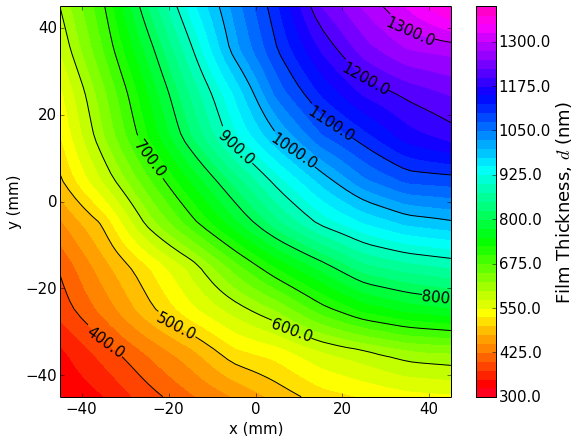

In [41]:

contour_plot(merged, 'd')


In [42]:
def plot_scatter(data_dict):
    ne = []
    mob = []
    d= []
    cond = []
    for key in data_dict.keys():
        try:
            c = 1/data_dict[key].get('rho') 
            cond.append(c)
            
        
            
            ne.append(data_dict[key].get('ne'))
            mob.append(data_dict[key].get('mob'))
            d.append(data_dict[key].get('d'))
            
            
        except:
            next
        
    fig = figure(figsize=(11,7))
    ax = fig.add_subplot(111)
    sizes = [50]*len(ne)
    
    sc = ax.scatter(ne, mob, c=d, s=sizes)
    ax.set_xlabel('$n_e$ (cm$^{-3}$)', size=18)
    ax.set_ylabel('$\mu_e$ (cm$^{2}$V$^{-1}$s$^{-1}$)', size=18)
    ax.tick_params(labelsize=15)
    CB = colorbar(sc)
    CB.set_label('Thickness, $d$ (nm)', size=18)
    CB.ax.tick_params(labelsize=15)
    
    
    
        
        
    
            

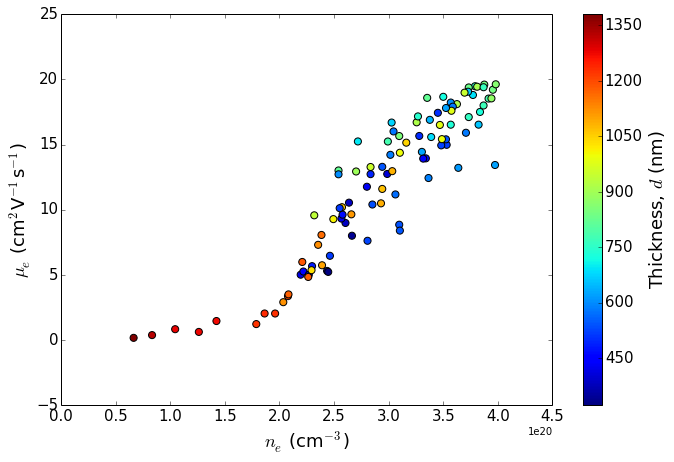

In [43]:
plot_scatter(merged)

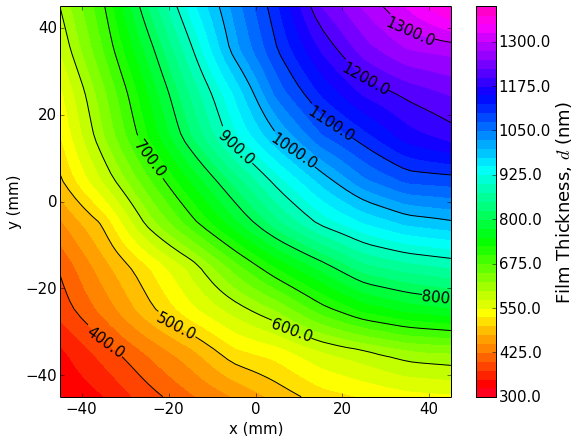

In [44]:
contour_plot(merged, 'd')

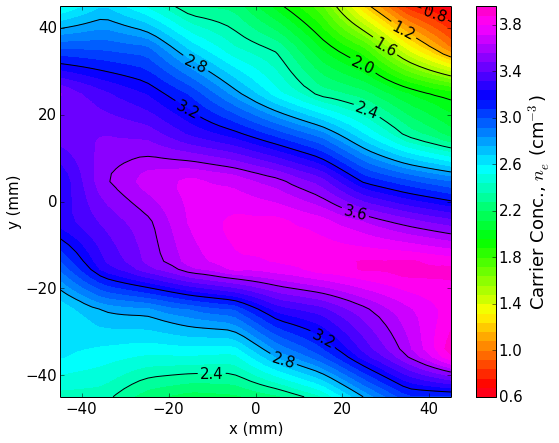

In [45]:
contour_plot(merged, 'ne')

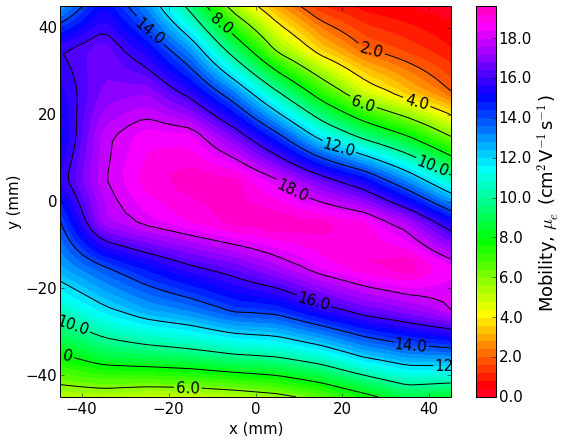

In [46]:
contour_plot(merged, 'mob')